![]()

# Stuff

Kevin J. Walchko, Phd

24 Jan 2021

---

## Bosch BNO055

![](https://cdn-shop.adafruit.com/640x480/4646-00.jpg)

I will use this as a reference to determine how well I am doing. You can get a qwiic version from [Adafruit](https://www.adafruit.com/product/4646)

| Sensor         | Range            | Bits | Hz  |
|:---------------|------------------|------|-----|
| Accelerometer  | $\pm$4 g         | 14   | 100 |
| Gyroscopes     | $\pm$2000 dps    | 16   | 100 |
| Magnetic (x-y) | $\pm$1300 $\mu$T | -    | 20  |
| Magnetic (z)   | $\pm$2500 $\mu$T | -    | 20  |
| Temperature    | -40$^\circ$ to +85$^\circ$ | -    | 1   |

In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from slurm.rate import Rate

from squaternion import Quaternion

import pandas as pd

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

In [6]:
def loadPickle(filename):
    with open(filename, 'rb') as fd:
        d = pickle.load(fd)
    return d

def getData(filename):
    imu = {
        "accel": [],
        "gyro": [],
        "mag": [],
        "pres": [],
        "temp": [],
        "stamp": []
    }
    
    bno = {
        "euler": {
            "roll": [],
            "pitch": [],
            "yaw": [],
            "time": []
        },
        "q": {
            "w": [],
            "x": [],
            "y": [],
            "z": [],
            "time": []
        }
    }
    
    stamp = []
    
    data = loadPickle(filename)
    tstart = data[0][-1]
    
    for d in data:
        a,g,m,p,t,q,e,dt = d
        imu["accel"].append(a)
        imu["gyro"].append(g)
        imu["mag"].append(m)
        imu["pres"].append(p)
        imu["temp"].append(t)
        imu["stamp"].append(dt - tstart)
        
        bno["q"]["w"].append(q[0])
        bno["q"]["x"].append(q[1])
        bno["q"]["y"].append(q[2])
        bno["q"]["z"].append(q[3])
        bno["q"]["time"].append(dt - tstart)
        bno["euler"]["roll"].append(e[0])
        bno["euler"]["pitch"].append(e[1])
        bno["euler"]["yaw"].append(e[2])
        bno["euler"]["time"].append(dt - tstart)
        
        stamp.append(dt - tstart)
    return imu, bno, stamp

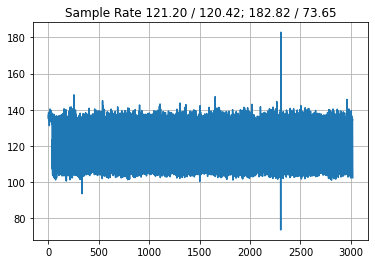

In [7]:
# fname = "../../software/python/data.pickle"
# fname = "../../software/python/dd.pickle"
fname = "../../software/python/simple.pickle"

imu, bno, stamp = getData(fname)

accel = np.array(imu["accel"])
gyro = np.array(imu["gyro"])
    
last = stamp[0]
hz = []
for t in stamp[1:]:
    hz.append(1.0/(t-last))
    last = t

# plt.plot(stamp[1:],hz)
plt.plot(hz)
plt.grid()
plt.title(f"Sample Rate {np.mean(hz):0.2f} / {np.median(hz):0.2f}; {max(hz):0.2f} / {min(hz):0.2f}");

# IMU Filter

In [8]:
class IMUFilter:
    """
    ref: Madgwick, An efficient orientation filter for inertial 
        and inertial/magnetic sensor arrays
    """
    bias = None
    mat = None
    
    def __init__(self, B, q=None):
        """
        q: [optional] initial quaternion, otherwise [1,0,0,0]
        B: Beta term in Madgwick's paper based on filter gradient learning 
        """
        self.wb = np.array([0,0,0])
        self.wcomp = True # estimate gyro bias
        self.wdr = 0.2 # gyro drift rate deg/sec/sec
        
        if q is None:
            self.q = Quaternion()
        else:
            self.q = q
            
        self.B = B

    def comp(self, del_f, dt):
        """
        Does the gyro compensation
        """
        q = self.q
        zeta = sqrt(3/4)*self.wdr*pi/180 # gyro drift: rad/s/s
        qwe = 2.0*q.conjugate*del_f # 47
        qwe = qwe.normalize
        self.wb = self.wb + zeta*np.array(qwe[1:])*dt # 48
        return self.wb

    def grad(self, a):
        """
        Calculates eqn #34, del_f/norm(del_f), which is the top
        block in the IMU flow diagram.
        """
        ax,ay,az = a
        q1,q2,q3,q4 = self.q

        fg = np.array([
            [2*(q2*q4-q1*q3)-ax],
            [2*(q1*q2+q3*q4)-ay],
            [2*(0.5-q2**2-q3**2)-az]
        ]) # 25
        Jg = np.array([
            [-2*q3,  2*q4, -2*q1, 2*q2],
            [ 2*q2,  2*q1,  2*q4, 2*q3],
            [    0, -4*q2, -4*q3,    0]
        ]) # 26, gradient of fg

        d = (Jg.T @ fg).T #[0]
        d = d.ravel()
        qq = Quaternion(*d).normalize 
        return qq.normalize

    def update(self, a, w, dt):
        """
        a: acceleration, term is normalize, so can be in any units
        w: gyro rates [rads/sec]
        dt: time step [sec]
        """
        a = a/norm(a)
        q = self.q
        del_f = self.grad(a) # gradient decent algorithm

        if self.wcomp:
            wb = self.comp(del_f,dt) # calculate bias
            w = w - wb               # 49
            
        qdw = 0.5*q*Quaternion(0,*w)
        qdot = qdw - self.B*del_f # filter
        q = q + qdot*dt           # integrate
        self.q = q.normalize
        return self.q

In [9]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"time":[]}
qq = {"w":[], "x":[],"y":[], "z":[],"time":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time
B = sqrt(3/4)*1*pi/180  # gyro measurement error rad/s
filt = IMUFilter(B)
filt.wcomp = False
filt.wdr = 0.9
wes = []

for a, g, ts in zip(accel, gyro, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g,dt)  # get orientation
    qq["w"].append(q[0])
    qq["x"].append(q[1])
    qq["y"].append(q[2])
    qq["z"].append(q[3])
    qq["time"].append(ts-start) # keep track of test time
    
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    e["time"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

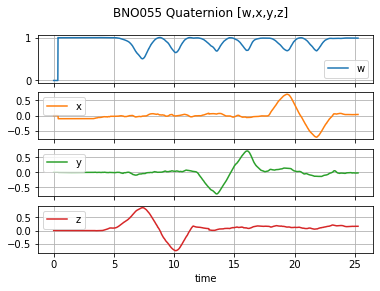

In [10]:
bnoq = pd.DataFrame(bno["q"])
bnoq.plot(
    x="time",
    subplots=True, grid=True, 
    title="BNO055 Quaternion [w,x,y,z]"
);

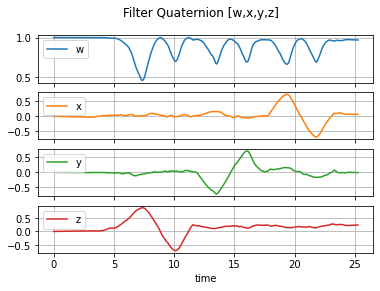

In [11]:
quat = pd.DataFrame(qq)
quat.plot(
    x="time", 
    subplots=True, grid=True, 
    title="Filter Quaternion [w,x,y,z]"
);

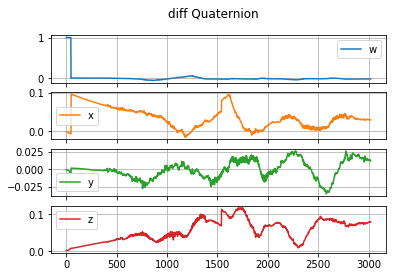

In [12]:
m = quat.iloc[:,:4] - bnoq.iloc[:,:4]
m.plot(
    subplots=True, grid=True, 
    title="diff Quaternion"
);

# MARG

In [13]:
class MARG:
    def __init__(self, B, Z):
        self.wb = np.array([0,0,0])
        self.q = Quaternion()
        self.wcomp = True
        self.B = B
        self.zeta = Z
        self.qwe = Quaternion(0,0,0,0)
        self.bias = np.array([0.,0.,0.])
        self.M = np.eye(3)
    
    def comp(self, del_f, dt):
        q = self.q
        qwe = 2.0*q.conjugate*del_f # 47
        self.qwe = self.qwe + qwe.normalize*dt
        self.wb = self.wb + self.zeta*np.array(self.qwe[1:]) # 48
        return self.wb

    def calc_b(self,m):
        # wiki: v' = q.v.q*
        q = self.q
        h = q*Quaternion(0,m[0],m[1],m[2])*q.conjugate # 45
        return (sqrt(h.x**2+h.y**2),0,h.z)             # 46

    def grad(self,a,m):
        ax,ay,az = a
        mx,my,mz = m
        bx,by,bz = self.calc_b(m) # calc Earth magnetic field reference
        q1,q2,q3,q4 = self.q

        fg = np.array([
            [2*(q2*q4-q1*q3)-ax],
            [2*(q1*q2+q3*q4)-ay],
            [2*(0.5-q2**2-q3**2)-az]
        ]) # 25
        Jg = np.array([
            [-2*q3,  2*q4, -2*q1, 2*q2],
            [ 2*q2,  2*q1,  2*q4, 2*q3],
            [    0, -4*q2, -4*q3,    0]
        ]) # 26

        fb = np.array([
            [2*bx*(0.5-q3**2-q4**2)+2*bz*(q2*q4-q1*q3)-mx],
            [    2*bx*(q2*q3-q1*q4)+2*bz*(q1*q2+q3*q4)-my],
            [2*bx*(q1*q3+q2*q4)+2*bz*(0.5-q2**2-q3**2)-mz]
        ]) # 29
        Jb = np.array([
            [        -2*bz*q3,         2*bz*q4, -4*bx*q3-2*bz*q1, -4*bx*q4+2*bz*q2],
            [-2*bx*q4+2*bz*q2, 2*bx*q3+2*bz*q1,  2*bx*q2+2*bz*q4, -2*bx*q1+2*bz*q3],
            [         2*bx*q3, 2*bx*q4-4*bz*q2,  2*bx*q1-4*bz*q3,          2*bx*q2]
        ]) # 30
    
        aa = np.vstack((Jg,Jb))  # [6x4]
        bb = np.vstack((fg,fb))  # [6x1]
        cc = (aa.T @ bb).ravel() # [4x6]*[6x1] = [4x1]
#         print(cc)
        self.q = Quaternion(*cc).normalize 
        return self.q

    def update(self,a,g,m,dt):
        a = a/norm(a)
        m = self.M @ (m - self.bias) 
#         m = m/norm(m)
        w = g
        q = self.q

        del_f = self.grad(a,m)   # gradient decent algorithm

        if self.wcomp:
            wb = self.comp(del_f,dt) # calculate bias
            w = w - wb               # 49
        
        qdw = 0.5*q*Quaternion(0,*w) # 
        qdot = qdw - self.B*del_f # filter
        q = q + qdot*dt    # integrate
        self.q = q.normalize
        return self.q

In [14]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"time":[]}
mq = {"w":[], "x":[], "y":[],"z":[],"time":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time

Z = sqrt(3/4)*0.0
B = sqrt(3/4)*0.01 # gyro measurement error rad/s
filt = MARG(B, Z)
filt.wcomp = True
filt.bias = np.array([-19.472,  33.003,  -1.579])
filt.M = np.array(
    [[0.987, 0.,    0.,   ],
     [0.,    0.964, 0.,   ],
     [0.,    0.,    1.,   ]]
)
wes = []

rad2deg = 180.0/np.pi

accel = np.array(imu["accel"])
gyro = np.array(imu["gyro"])
mag = np.array(imu["mag"])

for a, g, m, ts in zip(accel, gyro, mag, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g,m,dt)  # get orientation
    mq["w"].append(q.w)
    mq["x"].append(q.x)
    mq["y"].append(q.y)
    mq["z"].append(q.z)
    mq["time"].append(ts-start)
    
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    e["time"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

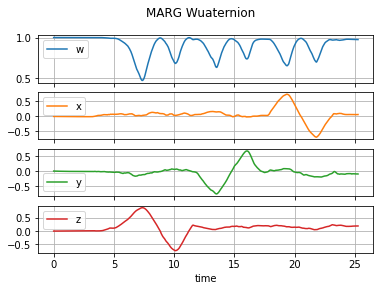

In [15]:
margq = pd.DataFrame(mq)
margq.plot(
    x="time", 
    subplots=True, 
    grid=True, 
    title="MARG Wuaternion"
);

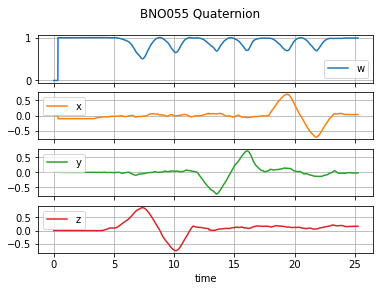

In [16]:
bnoquat = pd.DataFrame(bno["q"])
bnoquat.plot(
    x="time", 
    subplots=True, grid=True, 
    title="BNO055 Quaternion"
);

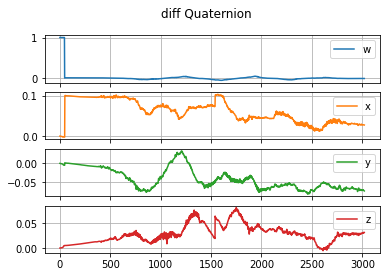

In [17]:
mm = margq.iloc[:,:4] - bnoquat.iloc[:,:4]
mm.plot(
    subplots=True, grid=True, 
    title="diff Quaternion"
);